In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Miniprojet/Deep_learning_project

/content/drive/MyDrive/Colab Notebooks/Miniprojet/Deep_learning_project


In [ ]:
import getpass
import os
import re
import json
from tqdm import tqdm #to see the progress of training
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.optim import AdamW
from sklearn.metrics import f1_score, accuracy_score
from transformers import get_scheduler
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import RobertaModel, RobertaTokenizer
from transformers import AutoTokenizer
import pandas as pd
import numpy as np

In [ ]:
!pip install -U accelerate
!pip install -U transformers

# DATASET preparation

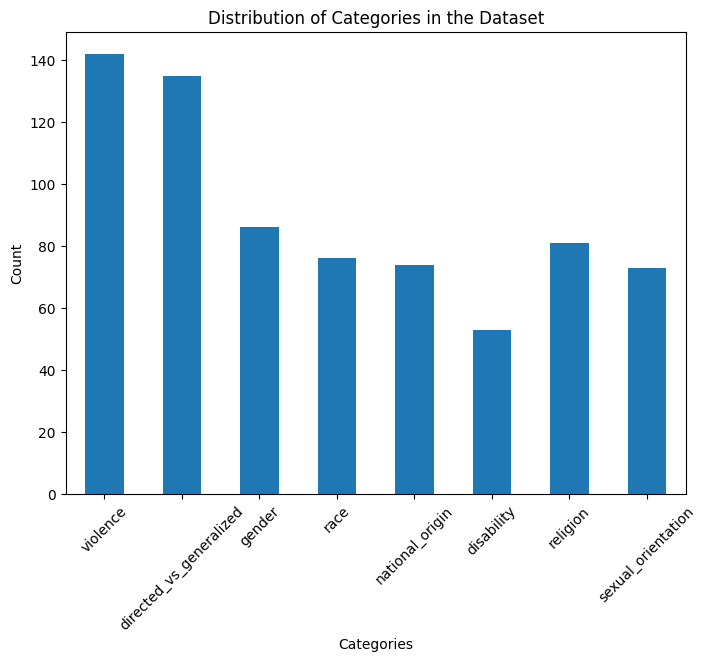

In [ ]:
# Convert dataset to pandas DataFrame for easier manipulation
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/Miniprojet/Deep_learning_project/ethos_dataset/ethos_multilabel.csv'

df = pd.read_csv(csv_file_path)

# Extract category counts
category_counts = df.drop(columns=['text']).sum()

# Plotting
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of Categories in the Dataset')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.head()

,text,violence,directed_vs_generalized,gender,race,national_origin,disability,religion,sexual_orientation
0,You should know women's sports are a joke,0,0,1,0,0,0,0,0
1,You look like Sloth with deeper Down’s syndrome,0,1,0,0,0,1,0,0
2,You look like Russian and speak like Indian. B...,1,1,0,0,1,0,0,0
3,"Women deserve to be abused, I guess.",1,0,1,0,0,0,0,0
4,Women are made for making babies and cooking d...,0,0,1,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
# Get the labels from the DataFrame
labels = df[['violence', 'directed_vs_generalized', 'gender', 'race', 'national_origin', 'disability', 'religion', 'sexual_orientation']].values.tolist()
labels = np.array(labels, dtype=np.float32)
# Get the texts
texts = df['text'].tolist()

# MODEL

In [ ]:
import torch
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels,
                                                                    test_size=0.15, random_state=35)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(labels[0]),
                                                            problem_type="multi_label_classification")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# path = F"/content/drive/MyDrive/Colab Notebooks/Miniprojet/Deep_learning_project/ethos_multilabel_classifier.pt"
# model.load_state_dict(torch.load(path))

In [ ]:
# Lets build custom dataset
class EthosDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': label
    }

In [ ]:
train_dataset = EthosDataset(train_texts, train_labels, tokenizer)
val_dataset = EthosDataset(val_texts, val_labels, tokenizer)

In [ ]:
# Multi-Label Classification Evaluation Metrics
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
from transformers import EvalPrediction
import torch


def multi_labels_metrics(predictions, labels, threshold=0.3):
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(predictions))

  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs>=threshold)] = 1
  y_true = labels

  f1 = f1_score(y_true, y_pred, average = 'macro')
  roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
  hamming = hamming_loss(y_true, y_pred)

  metrics = {
      "roc_auc": roc_auc,
      "hamming_loss": hamming,
      "f1": f1
  }

  return metrics

def compute_metrics(p:EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

  result = multi_labels_metrics(predictions=preds,
                                labels=p.label_ids)

  return result

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
# Training Arguments
from transformers import TrainingArguments, Trainer,EarlyStoppingCallback

args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir = './results',
    num_train_epochs=5,
    save_steps=46,
    save_total_limit=2,
    logging_steps=23,
    evaluation_strategy='steps',  # Evaluate every 10 steps
    save_strategy='steps',  # Save model every 10 steps
    load_best_model_at_end=True,
)

trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics=compute_metrics,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=1)])

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Roc Auc,Hamming Loss,F1,Runtime,Samples Per Second,Steps Per Second
23,0.586900,0.504315,0.512649,0.290385,0.116950,0.638400,101.815000,14.097000
46,0.489700,0.459673,0.574561,0.267308,0.257289,0.507800,128.005000,17.724000
69,0.425100,0.388691,0.814634,0.146154,0.694231,0.353900,183.667000,25.431000
92,0.362400,0.335359,0.847294,0.142308,0.755227,0.443300,146.611000,20.300000
115,0.301600,0.299996,0.880281,0.096154,0.807127,0.531700,122.243000,16.926000
138,0.262600,0.280323,0.881123,0.084615,0.818823,0.372100,174.694000,24.188000
161,0.225200,0.261287,0.883231,0.086538,0.817881,0.287000,226.458000,31.356000
184,0.216000,0.252655,0.891060,0.088462,0.827899,0.305300,212.923000,29.482000
207,0.198100,0.245600,0.889800,0.084615,0.828656,0.286000,227.311000,31.474000
230,0.188700,0.244042,0.885973,0.090385,0.821178,0.283900,228.945000,31.700000


TrainOutput(global_step=230, training_loss=0.32562102856843367, metrics={'train_runtime': 70.7196, 'train_samples_per_second': 26.018, 'train_steps_per_second': 3.252, 'total_flos': 60941523517440.0, 'train_loss': 0.32562102856843367, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.24404235184192657,
 'eval_roc_auc': 0.885973098310973,
 'eval_hamming_loss': 0.09038461538461538,
 'eval_f1': 0.8211778301064014,
 'eval_runtime': 0.5293,
 'eval_samples_per_second': 122.795,
 'eval_steps_per_second': 17.002,
 'epoch': 5.0}

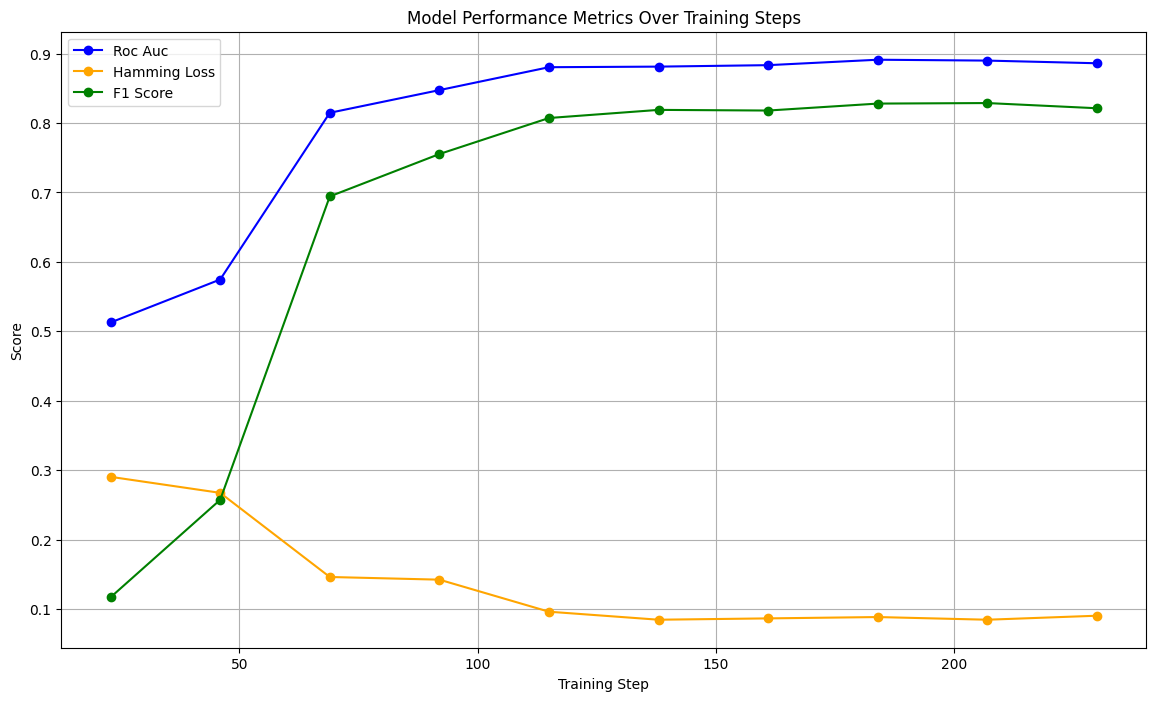

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data provided
data = {
    'Step': [23, 46, 69, 92, 115, 138, 161, 184, 207, 230],
    'ROC AUC': [0.512649, 0.574561, 0.814634, 0.847294, 0.880281, 0.881123, 0.883231, 0.891060, 0.889800, 0.885973],
    'Hamming Loss': [0.290385, 0.267308, 0.146154, 0.142308, 0.096154, 0.084615, 0.086538, 0.088462, 0.084615, 0.090385],
    'F1': [0.116950, 0.257289, 0.694231, 0.755227, 0.807127, 0.818823, 0.817881, 0.827899, 0.828656, 0.821178]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(14, 8))

# Roc Auc
plt.plot(df['Step'], df['ROC AUC'], marker='o', color='b', label='Roc Auc')
# Hamming Loss
plt.plot(df['Step'], df['Hamming Loss'], marker='o', color='orange', label='Hamming Loss')
# F1 Score
plt.plot(df['Step'], df['F1'], marker='o',color='g', label='F1 Score')

# Adding titles and labels
plt.title('Model Performance Metrics Over Training Steps')
plt.xlabel('Training Step')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#model_save_name = 'ethos_multilabel_classifier.pt'
#path = F"/content/drive/MyDrive/Colab Notebooks/Miniprojet/Deep_learning_project/{model_save_name}"
#torch.save(model.state_dict(), path)

# Predictions

In [ ]:
text = "Muslim stink as hell"

encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

In [ ]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=0.4)] = 1

preds

array([1., 0., 0., 0., 0., 0., 1., 0.])

In [ ]:
label_names = ['violence', 'directed_vs_generalized', 'gender', 'race', 'national_origin', 'disability', 'religion', 'sexual_orientation']
label_dict = {i: name for i, name in enumerate(label_names)}
label_list = [label_dict[i] for i, value in enumerate(preds) if value == 1]

print(label_list)

['violence', 'religion']
